https://hyunhp.tistory.com/376

## unet
- 이미지 분할<br>
 🐾 이미지에서 개체가 있는 위치, 해당 개체의 모양, 어떤 픽셀이 어떤객체에 속하는지 등을 알고 싶다면 이미지를 분할하고 싶을 것임<br>
 🐾 이미지의 각 픽셀에 레이블이 부여됨
 - 따라서 영상분할의 과제는 영상의 픽셀 단위의 마스크를 출력하도록 신경망을 훈련시키는 것
 - 픽셀 레벨에서 이미지를 이해하는데 도움이 됨
 - 이미지 분할은 의료영상, 자율주행차, 위성 영상화 분야에서 많이 응용되고 있음

### 사용할 데이터 세트 : 복부 xray(장내 용종, 종양 절제술 전후 사진)
- 데이터 세트는 해당 레이블과 픽셀단위의 마스크로 구성됨
  - class 1(air) : 복부 내 공기를 표시한 픽셀
  - class 2(_background) : class1에 속하지 않는 경우/ 주변 픽셀

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Packages

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

import cv2 
from PIL import Image


## 2. Load and split the Data

In [ ]:
import os
import numpy as np
import pandas as pd

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

input_dir = '/content/drive/MyDrive/최종 프로젝트/unet_라벨이미지(수정)/Train_validation_image(수정)-validation 나누기/train/image/'
target_dir = '/content/drive/MyDrive/최종 프로젝트/unet_라벨이미지(수정)/Train_validation_image(수정)-validation 나누기/train/label/'

# sorted함수를 사용하여 정렬된 파일 리스트를 반환
# 이터러블 객체도 받을 수 있음 
image_list = sorted(
    [
     os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith('.jpg')
    ])

mask_list = sorted(
    [
     os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith('png') and not fname.startswith('.')
    ])

In [ ]:
val_input_dir = '/content/drive/MyDrive/최종 프로젝트/unet_라벨이미지(수정)/Train_validation_image(수정)-validation 나누기/validation/image/'
val_target_dir = '/content/drive/MyDrive/최종 프로젝트/unet_라벨이미지(수정)/Train_validation_image(수정)-validation 나누기/validation/label/'

# sorted함수를 사용하여 정렬된 파일 리스트를 반환
# 이터러블 객체도 받을 수 있음 
val_image_list = sorted(
    [
     os.path.join(val_input_dir, fname)
     for fname in os.listdir(val_input_dir)
     if fname.endswith('.jpg')
    ]
)

val_mask_list = sorted(
    [
     os.path.join(val_target_dir, fname)
     for fname in os.listdir(val_target_dir)
     if fname.endswith('png') and not fname.startswith('.')
    ]
)


Train이미지와 마스크 데이터 확인하기

Text(0.5, 1.0, 'Segmentation')

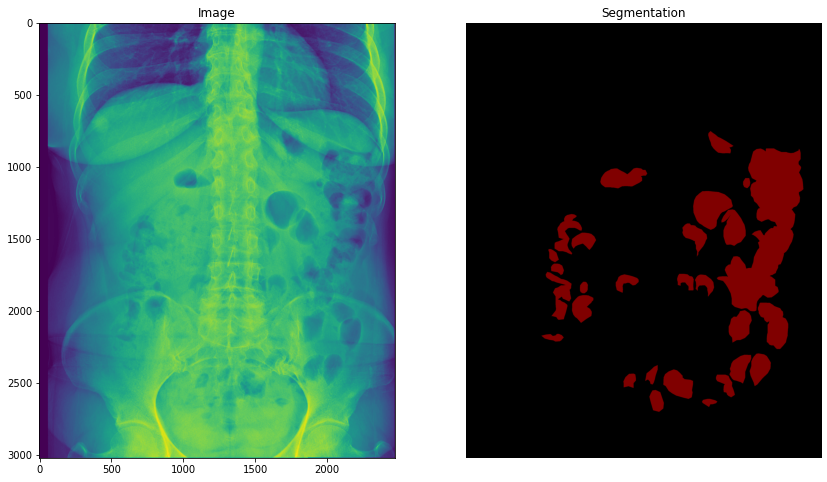

In [ ]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0])for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
plt.axis('off')
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

✅__train/ validation dataset__으로 나누기

▶ Train 데이터셋을 이미지와 마스크이미지로 분할

In [ ]:
#Train
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
  print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/\xe1\x84\x8e\xe1\x85\xac\xe1\x84\x8c\xe1\x85\xa9\xe1\x86\xbc \xe1\x84\x91\xe1\x85\xb3\xe1\x84\x85\xe1\x85\xa9\xe1\x84\x8c\xe1\x85\xa6\xe1\x86\xa8\xe1\x84\x90\xe1\x85\xb3/unet_\xe1\x84\x85\xe1\x85\xa1\xe1\x84\x87\xe1\x85\xa6\xe1\x86\xaf\xe1\x84\x8b\xe1\x85\xb5\xe1\x84\x86\xe1\x85\xb5\xe1\x84\x8c\xe1\x85\xb5(\xe1\x84\x89\xe1\x85\xae\xe1\x84\x8c\xe1\x85\xa5\xe1\x86\xbc)/Train_validation_image(\xe1\x84\x89\xe1\x85\xae\xe1\x84\x8c\xe1\x85\xa5\xe1\x86\xbc)-validation \xe1\x84\x82\xe1\x85\xa1\xe1\x84\x82\xe1\x85\xae\xe1\x84\x80\xe1\x85\xb5/train/image/02715030000.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/\xe1\x84\x8e\xe1\x85\xac\xe1\x84\x8c\xe1\x85\xa9\xe1\x86\xbc \xe1\x84\x91\xe1\x85\xb3\xe1\x84\x85\xe1\x85\xa9\xe1\x84\x8c\xe1\x85\xa6\xe1\x86\xa8\xe1\x84\x90\xe1\x85\xb3/unet_\xe1\x84\x85\xe1\x85\xa1\xe1\x84\x87\xe1\x85\xa6\xe1\x86\xaf\xe1\x84\x8b\xe1\x85\xb5\xe1\x84\x86\xe1\x85\xb5\xe1\x84\x8c

In [ ]:
image_filenames = tf.constant(image_list)
mask_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, mask_filenames))

for image, mask in dataset.take(1):
  print(image)
  print(mask)

tf.Tensor(b'/content/drive/MyDrive/\xe1\x84\x8e\xe1\x85\xac\xe1\x84\x8c\xe1\x85\xa9\xe1\x86\xbc \xe1\x84\x91\xe1\x85\xb3\xe1\x84\x85\xe1\x85\xa9\xe1\x84\x8c\xe1\x85\xa6\xe1\x86\xa8\xe1\x84\x90\xe1\x85\xb3/unet_\xe1\x84\x85\xe1\x85\xa1\xe1\x84\x87\xe1\x85\xa6\xe1\x86\xaf\xe1\x84\x8b\xe1\x85\xb5\xe1\x84\x86\xe1\x85\xb5\xe1\x84\x8c\xe1\x85\xb5(\xe1\x84\x89\xe1\x85\xae\xe1\x84\x8c\xe1\x85\xa5\xe1\x86\xbc)/Train_validation_image(\xe1\x84\x89\xe1\x85\xae\xe1\x84\x8c\xe1\x85\xa5\xe1\x86\xbc)-validation \xe1\x84\x82\xe1\x85\xa1\xe1\x84\x82\xe1\x85\xae\xe1\x84\x80\xe1\x85\xb5/train/image/02715030000.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/\xe1\x84\x8e\xe1\x85\xac\xe1\x84\x8c\xe1\x85\xa9\xe1\x86\xbc \xe1\x84\x91\xe1\x85\xb3\xe1\x84\x85\xe1\x85\xa9\xe1\x84\x8c\xe1\x85\xa6\xe1\x86\xa8\xe1\x84\x90\xe1\x85\xb3/unet_\xe1\x84\x85\xe1\x85\xa1\xe1\x84\x87\xe1\x85\xa6\xe1\x86\xaf\xe1\x84\x8b\xe1\x85\xb5\xe1\x84\x86\xe1\x85\xb5\xe1\x84\x8c\xe1\x85\xb5(\xe1\x84\x89\xe1\x85\xae\xe1\

▶ Validation 데이터셋을 이미지와 마스크이미지로 분할

In [ ]:
#validation
val_image_list_ds = tf.data.Dataset.list_files(val_image_list, shuffle=False)
val_mask_list_ds = tf.data.Dataset.list_files(val_mask_list, shuffle=False)

for val_path in zip(val_image_list_ds.take(3), val_mask_list_ds.take(3)):
  print(val_path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/\xe1\x84\x8e\xe1\x85\xac\xe1\x84\x8c\xe1\x85\xa9\xe1\x86\xbc \xe1\x84\x91\xe1\x85\xb3\xe1\x84\x85\xe1\x85\xa9\xe1\x84\x8c\xe1\x85\xa6\xe1\x86\xa8\xe1\x84\x90\xe1\x85\xb3/unet_\xe1\x84\x85\xe1\x85\xa1\xe1\x84\x87\xe1\x85\xa6\xe1\x86\xaf\xe1\x84\x8b\xe1\x85\xb5\xe1\x84\x86\xe1\x85\xb5\xe1\x84\x8c\xe1\x85\xb5(\xe1\x84\x89\xe1\x85\xae\xe1\x84\x8c\xe1\x85\xa5\xe1\x86\xbc)/Train_validation_image(\xe1\x84\x89\xe1\x85\xae\xe1\x84\x8c\xe1\x85\xa5\xe1\x86\xbc)-validation \xe1\x84\x82\xe1\x85\xa1\xe1\x84\x82\xe1\x85\xae\xe1\x84\x80\xe1\x85\xb5/validation/image/10843610000.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/\xe1\x84\x8e\xe1\x85\xac\xe1\x84\x8c\xe1\x85\xa9\xe1\x86\xbc \xe1\x84\x91\xe1\x85\xb3\xe1\x84\x85\xe1\x85\xa9\xe1\x84\x8c\xe1\x85\xa6\xe1\x86\xa8\xe1\x84\x90\xe1\x85\xb3/unet_\xe1\x84\x85\xe1\x85\xa1\xe1\x84\x87\xe1\x85\xa6\xe1\x86\xaf\xe1\x84\x8b\xe1\x85\xb5\xe1\x84\x86\xe1\x85\xb5\xe1\x8

In [ ]:
val_image_filenames = tf.constant(val_image_list)
val_mask_filenames = tf.constant(val_mask_list)

val_dataset = tf.data.Dataset.from_tensor_slices((val_image_filenames, val_mask_filenames))

for image, mask in val_dataset.take(1):
  print(image)
  print(mask)

tf.Tensor(b'/content/drive/MyDrive/\xe1\x84\x8e\xe1\x85\xac\xe1\x84\x8c\xe1\x85\xa9\xe1\x86\xbc \xe1\x84\x91\xe1\x85\xb3\xe1\x84\x85\xe1\x85\xa9\xe1\x84\x8c\xe1\x85\xa6\xe1\x86\xa8\xe1\x84\x90\xe1\x85\xb3/unet_\xe1\x84\x85\xe1\x85\xa1\xe1\x84\x87\xe1\x85\xa6\xe1\x86\xaf\xe1\x84\x8b\xe1\x85\xb5\xe1\x84\x86\xe1\x85\xb5\xe1\x84\x8c\xe1\x85\xb5(\xe1\x84\x89\xe1\x85\xae\xe1\x84\x8c\xe1\x85\xa5\xe1\x86\xbc)/Train_validation_image(\xe1\x84\x89\xe1\x85\xae\xe1\x84\x8c\xe1\x85\xa5\xe1\x86\xbc)-validation \xe1\x84\x82\xe1\x85\xa1\xe1\x84\x82\xe1\x85\xae\xe1\x84\x80\xe1\x85\xb5/validation/image/10843610000.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/\xe1\x84\x8e\xe1\x85\xac\xe1\x84\x8c\xe1\x85\xa9\xe1\x86\xbc \xe1\x84\x91\xe1\x85\xb3\xe1\x84\x85\xe1\x85\xa9\xe1\x84\x8c\xe1\x85\xa6\xe1\x86\xa8\xe1\x84\x90\xe1\x85\xb3/unet_\xe1\x84\x85\xe1\x85\xa1\xe1\x84\x87\xe1\x85\xa6\xe1\x86\xaf\xe1\x84\x8b\xe1\x85\xb5\xe1\x84\x86\xe1\x85\xb5\xe1\x84\x8c\xe1\x85\xb5(\xe1\x84\x89\xe1\x85\xae

In [ ]:
#이미지 데이터 전처리 함수 정의
def process_path(image_path, mask_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_png(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=3)
  mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
  return img, mask

def preprocess(image, mask):
  input_image = tf.image.resize(image, (128, 96), method='nearest')
  input_mask = tf.image.resize(mask, (128, 96), method='nearest')

  return input_image, input_mask/128


#Train dataset
image_ds = dataset.map(process_path)
train_processed_image_ds = image_ds.map(preprocess)

#validation dataset
val_image_ds = val_dataset.map(process_path)
val_processed_image_ds = val_image_ds.map(preprocess)

## 3. U-Net

▶ Encoder (Downsampling Block)

In [ ]:
# UNQ_C1
# GRADED FUNCTION: conv_block
def conv_block(inputs = None, n_filters=32, dropout_prob=0, max_pooling=True):
  """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
  #start code
  conv = Conv2D(n_filters, #Number of filters
                3, #kernel size
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(inputs)
  conv = Conv2D(n_filters, #Number of filters
                3, #kernel size
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(conv)

  #end code here

  #if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
  if dropout_prob > 0:
    conv = Dropout(dropout_prob)(conv)

  #if max_pooling is True add a MaxPooling2D with 2x2 pool_size
  if max_pooling:
    next_layer = MaxPooling2D()(conv)

  else:
    next_layer = conv

  skip_connection = conv

  return next_layer, skip_connection


In [ ]:
input_size=(128, 96, 3)
n_filters = 32
inputs = Input(input_size)
cblock1 =  conv_block(inputs, n_filters * 1)
model1 = tf.keras.Model(inputs = inputs, outputs=cblock1)

output1 = [['lnputLayer', [(None, 128, 96, 3)], 0],
           ['Conv2D', (None, 128, 96, 32), 896, 'same', 'relu', 'HeNormal'],
           ['Conv2D', (None, 128, 96, 32), 9248, 'same', 'relu', 'HeNormal'],
           ['MaxPooling2D', (None, 64, 48, 32), 0, (2, 2)]]
'''
print('Block1:')
for layer in summary(model1):
  print(layer)

comparator(summary(model1), output1)
'''

inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 32, dropout_prob=0.1, max_pooling=True)
model2 = tf.keras.Model(inputs = inputs, outputs = cblock1)

output2 = [['InputLayer', [(None, 128, 96, 3)], 0],
            ['Conv2D', (None, 128, 96, 1024), 28672, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 128, 96, 1024), 9438208, 'same', 'relu', 'HeNormal'],
            ['Dropout', (None, 128, 96, 1024), 0, 0.1],
            ['MaxPooling2D', (None, 64, 48, 1024), 0, (2, 2)]]
'''           
print('\nBlock 2:')   
for layer in summary(model2):
  print(layer)
    
comparator(summary(model2), output2)
'''

"           \nprint('\nBlock 2:')   \nfor layer in summary(model2):\n  print(layer)\n    \ncomparator(summary(model2), output2)\n"

▶ Decoder(Upsampling Block)

In [ ]:
# UNQ_C2
#GRADED FUNCTION : upsampling_block
def upsampling_block(expansive_input, contractive_input, n_filters=32):
  """
  Convolutional upsampling block
  Arguments:
    expansive_input -- Input tensor from previous layer
    contractive_input -- Input tensor from previous skip layer
    n_filters -- Number of filters for the convolutional layers
  Returns: 
    conv -- Tensor output
  """
  up = Conv2DTranspose(
      n_filters, #Number of filters
      (3, 3), #kernel size
      strides=2,
      padding='same')(expansive_input)

  #Merge the previous output and the contractive_input
  merge = concatenate([up, contractive_input], axis=3)
  conv = Conv2D(n_filters,
                (3, 3),
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(merge)
  conv = Conv2D(n_filters,
                (3, 3),
                activation='relu',
                padding='same',
                kernel_initializer='he_normal')(conv)

  return conv

In [ ]:
input_size1 = (16, 12, 256)
input_size2 = (32, 24, 128)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs = Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

▶ Build the Model

In [ ]:
# UNQ_C3
# GRADED FUNCTION: unet_model
def unet_model(input_size=(128, 96, 3), n_filters=32, n_classes=2):
  """
  Unet model
    
  Arguments:
      input_size -- Input shape 
      n_filters -- Number of filters for the convolutional layers
      n_classes -- Number of output classes
  Returns: 
      model -- tf.keras.Model
  """
  inputs = Input(input_size)
  #Contracting Path(encoding)
  #Add a conv_block with the inputs of the unet_model and n_filters

  cblock1 = conv_block(inputs, n_filters)
  #Chain the first element of the output of each block to be the input of the next conv_block
  #Double the number of filters at each new step
  cblock2 = conv_block(cblock1[0], n_filters * 2)
  cblock3 = conv_block(cblock2[0], n_filters * 4)
  cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=0.3)# Include a dropout_prob of 0.3 for this layer

  #Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
  cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob=0.3, max_pooling=False)


  #Expanding Path(decoding)
  # Add the first upsampling_block
  # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters *8
  ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 8)
  # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
  # Note that you must use the second element of the contractive block i.e before the maxpooling layer.
  #At each step, use half the number of filters of the previous block
  ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 4)
  ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2)
  ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)

  conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

  #Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
  conv10 = Conv2D(n_classes, (1, 1), padding='same')(conv9)

  model = tf.keras.Model(inputs=inputs, outputs=conv10)

  return model

▶ Set Model Demensions

In [ ]:
img_height = 128
img_width = 96
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [ ]:
unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 96, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 96, 32)  896         ['input_5[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 128, 96, 32)  9248        ['conv2d_6[0][0]']               
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 64, 48, 32)  0           ['conv2d_7[0][0]']         

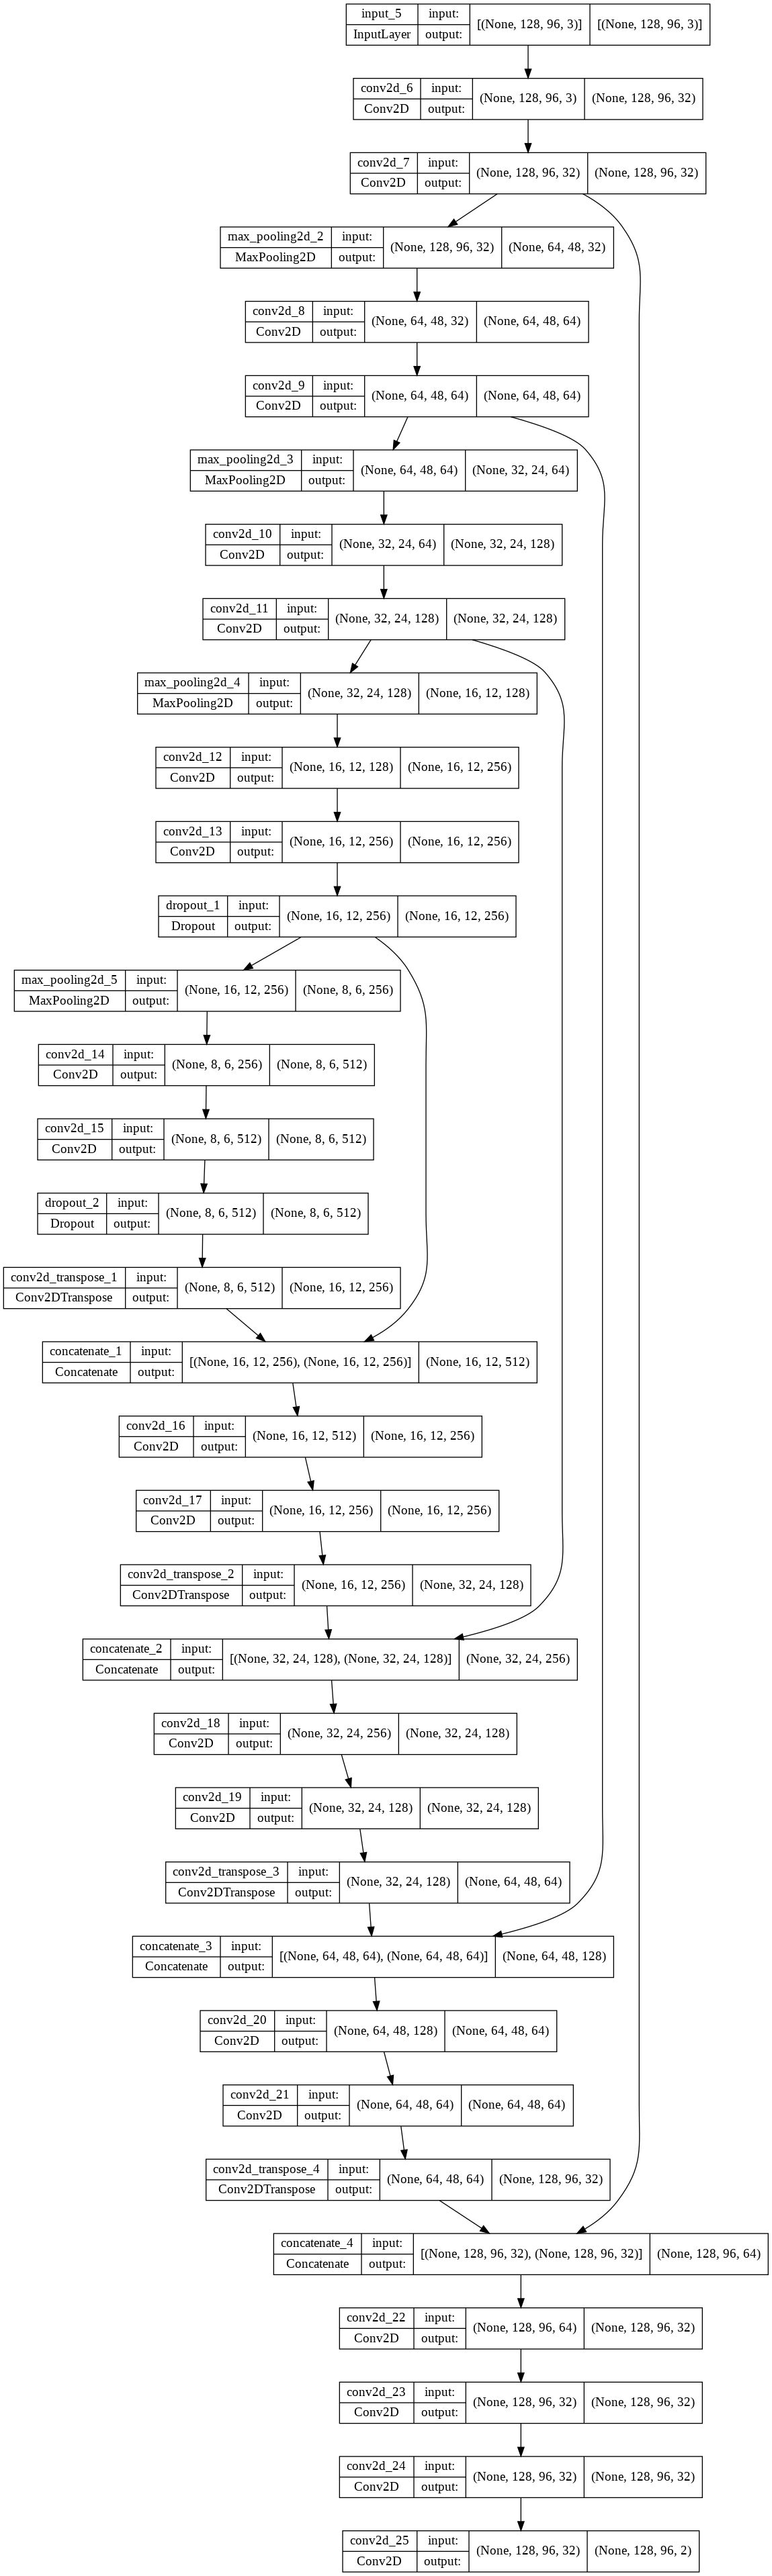

In [ ]:
#unet 모델의 구조를 확인하기
tf.keras.utils.plot_model(unet, show_shapes=True)

▶ Loss Function
- you'll use sparse categorical crossentropy as your loss function, to perform pixel-wise multiclass prediction
- Sparse categorical crossentropy is more efficient than other loss functions when you're dealing with lots of classes

In [ ]:
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'], run_eagerly=True)

▶ Dataset Handling

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), 'gray')
    plt.axis('off')
  plt.show()

(3024, 2520, 3)
(3024, 2520, 1)


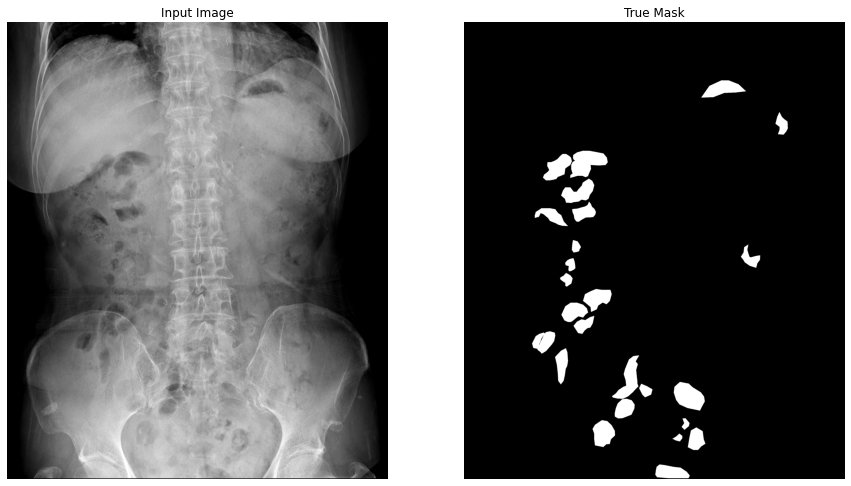

In [ ]:
for image, mask in image_ds.take(1):
  sample_image, sample_mask = image, mask
  print(image.shape)
  print(mask.shape)
display([sample_image, sample_mask])

## 4. Load Weights

In [ ]:
# Call-back 함수
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath='/content/sample_data/-{epoch:03d}-{val_loss:.4f}-{val_accuracy:.4f}.hdf5',
            monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# 학습과정 진행사항 확인
TB = TensorBoard(log_dir='logs', write_graph=True, write_images=True)

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)
# patience(3) 번 동안 validation set에서의 loss가 떨어지지 않으면, learning rate를 0.8만큼 곱해라
# 0.001 -> 0.0008 -> 0.00064 -> 0.00051xx...

CALLBACK = [CP, TB, LR]


In [ ]:
EPOCHS = 100
VAL_SUBSPLITS = 3
BUFFER_SIZE = 500
BATCH_SIZE = 2
processed_image_ds.batch(BATCH_SIZE)
train_dataset = train_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_processed_image_ds.cache().batch(BATCH_SIZE)

In [ ]:
unet.load_weights('/content/drive/MyDrive/최종 프로젝트/unet_라벨이미지(수정)/Train_validation_image(수정)-validation 나누기/-017-0.2834-0.8944.hdf5')

In [ ]:
unet.predict(train_dataset, verbose=1)

39/39 [==============================] - 35s 259ms/step


array([[[[ 0.59008455, -0.47266328],
         [ 0.9446661 , -0.7999545 ],
         [ 1.8266319 , -1.422111  ],
         ...,
         [ 1.3556274 , -1.2444429 ],
         [ 1.1425828 , -0.7205661 ],
         [ 0.83009356, -0.69614667]],

        [[ 0.9631606 , -0.45997977],
         [ 1.7826673 , -1.2303768 ],
         [ 2.168763  , -2.046336  ],
         ...,
         [ 2.517692  , -2.2911918 ],
         [ 1.0230471 , -1.6182051 ],
         [ 0.94637775, -1.257465  ]],

        [[ 0.6383724 , -1.3008707 ],
         [ 2.008802  , -1.4057432 ],
         [ 2.2353253 , -2.5722055 ],
         ...,
         [ 1.9690921 , -2.5515385 ],
         [ 1.4913745 , -2.4547176 ],
         [ 1.4611682 , -1.4718195 ]],

        ...,

        [[ 3.790207  , -2.3576767 ],
         [ 3.5369453 , -4.9899626 ],
         [ 4.480283  , -4.724679  ],
         ...,
         [ 4.7328377 , -5.101197  ],
         [ 4.447033  , -4.4436197 ],
         [ 3.0381804 , -2.603949  ]],

        [[ 1.8430411 , -2.9754615 

In [ ]:
for image, mask in train_dataset.take(1):
  print(mask.shape)

(2, 128, 96, 1)


### Predict

▶ Create Predicted Masks

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


▶ Show Predictions

In [ ]:
# 훈련이미지와 예측이미지 비교
def show_predictions(dataset=None, num=1):
  """
  Displays the first image of each of the num batches
  """
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask/128,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])
    

🐾 공기 마스크 type에러 해결
- 마스크 이미지의 astype(tf.float32) 형 변환이 안됨
- 그래서
```
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior(prefer_float32=False)
```
사용하여 마스크 이미지를 int64에서 float32로 변환


In [ ]:
np_config.enable_numpy_behavior?

Test

In [ ]:
#### Test

In [ ]:
test_input_dir = '/content/drive/MyDrive/최종 프로젝트/unet_라벨이미지(수정)/Test_images/image/'
test_target_dir = '/content/drive/MyDrive/최종 프로젝트/unet_라벨이미지(수정)/Test_images/label/'

test_image_list = sorted(
    [
     os.path.join(test_input_dir, fname)
     for fname in os.listdir(test_input_dir)
     if fname.endswith('.jpg')
    ]
)

test_mask_list = sorted(
    [
     os.path.join(test_target_dir, fname)
     for fname in os.listdir(test_target_dir)
     if fname.endswith('png') and not fname.startswith('.')
    ]
)

In [ ]:
#이미지와 라벨이 일치하는 지 확인 
test_image_list_ds = tf.data.Dataset.list_files(test_image_list, shuffle=False)
test_mask_list_ds = tf.data.Dataset.list_files(test_mask_list, shuffle=False)

for path in zip(test_image_list_ds.take(3), test_mask_list_ds.take(3)):
  print(path)


#
test_image_filenames = tf.constant(test_image_list)
test_mask_filenames = tf.constant(test_mask_list)

test_dataset = tf.data.Dataset.from_tensor_slices((test_image_filenames, test_mask_filenames))

test_image_ds = test_dataset.map(process_path)
test_processed_image_ds = test_image_ds.map(preprocess)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/\xe1\x84\x8e\xe1\x85\xac\xe1\x84\x8c\xe1\x85\xa9\xe1\x86\xbc \xe1\x84\x91\xe1\x85\xb3\xe1\x84\x85\xe1\x85\xa9\xe1\x84\x8c\xe1\x85\xa6\xe1\x86\xa8\xe1\x84\x90\xe1\x85\xb3/unet_\xe1\x84\x85\xe1\x85\xa1\xe1\x84\x87\xe1\x85\xa6\xe1\x86\xaf\xe1\x84\x8b\xe1\x85\xb5\xe1\x84\x86\xe1\x85\xb5\xe1\x84\x8c\xe1\x85\xb5(\xe1\x84\x89\xe1\x85\xae\xe1\x84\x8c\xe1\x85\xa5\xe1\x86\xbc)/Test_images/image/abdomen_1.jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/\xe1\x84\x8e\xe1\x85\xac\xe1\x84\x8c\xe1\x85\xa9\xe1\x86\xbc \xe1\x84\x91\xe1\x85\xb3\xe1\x84\x85\xe1\x85\xa9\xe1\x84\x8c\xe1\x85\xa6\xe1\x86\xa8\xe1\x84\x90\xe1\x85\xb3/unet_\xe1\x84\x85\xe1\x85\xa1\xe1\x84\x87\xe1\x85\xa6\xe1\x86\xaf\xe1\x84\x8b\xe1\x85\xb5\xe1\x84\x86\xe1\x85\xb5\xe1\x84\x8c\xe1\x85\xb5(\xe1\x84\x89\xe1\x85\xae\xe1\x84\x8c\xe1\x85\xa5\xe1\x86\xbc)/Test_images/label/abdomen_1.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/d

In [ ]:
test_dataset = test_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

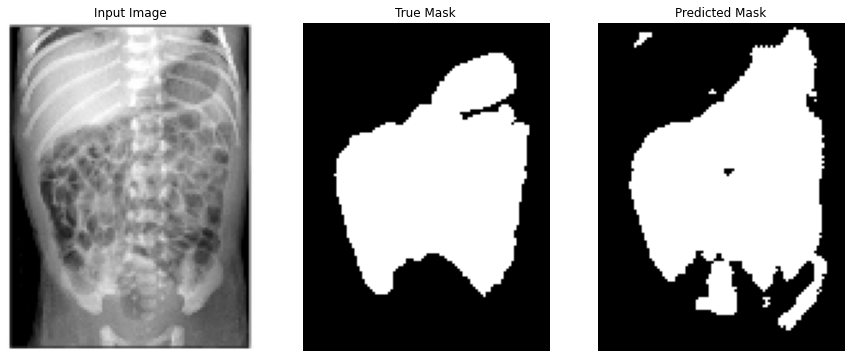

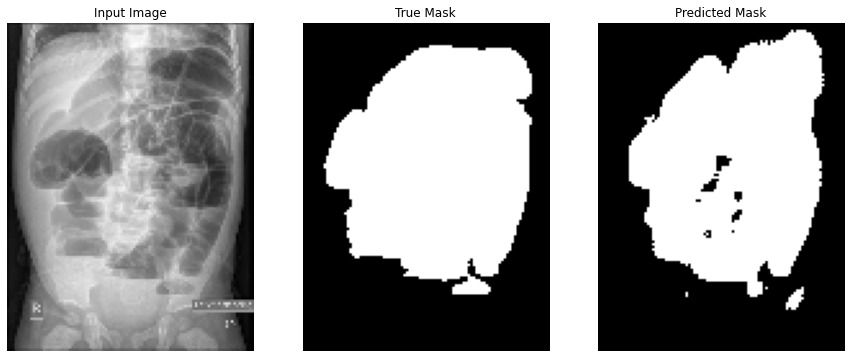

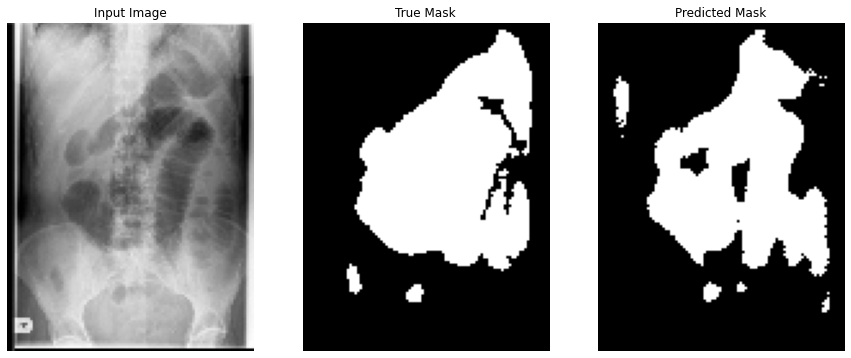

In [ ]:
show_predictions(test_dataset, 3)

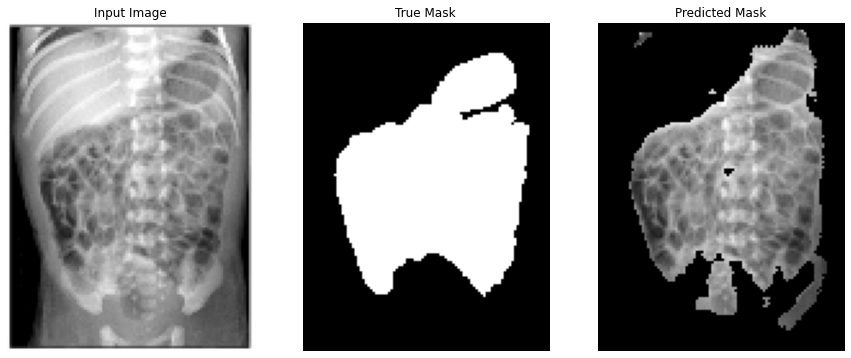

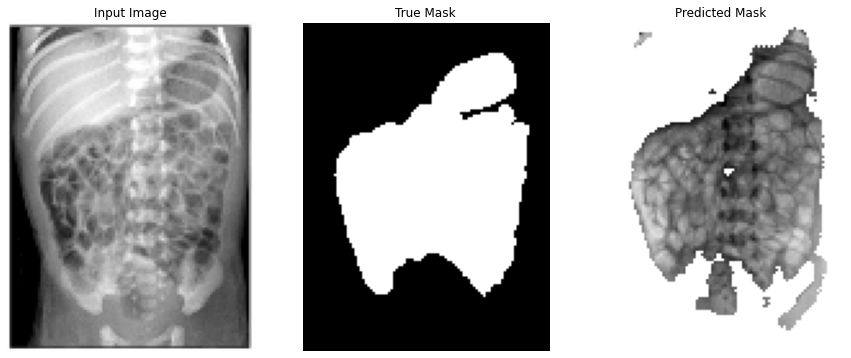

0.5995145542983664

In [ ]:
#test dataset 공기 정량화

for image, mask in test_dataset.take(1):
  pred_mask = unet.predict(image)
  pred_mask = create_mask(pred_mask).astype(tf.float32)
  display([image[0], mask[0], image[0] * pred_mask])
  #1-air(여기서 밝기 이미지 주기)
  display([image[0], mask[0], 1-(image[0]*pred_mask)])

image[0] * create_mask(pred_mask).astype(tf.float32)

##air 양 구하기!!

arr_a=np.array(1-image[0]*pred_mask) #공기층이 어두울 수록 높은 값 가지므로 1을 빼줌

# Pred_mask에 1을 빼서 반전시키기(흑백이미지)
pred_mask = np.array(pred_mask)
black = tf.keras.preprocessing.image.array_to_img(np.ones((128,96,1))-pred_mask)
arr_black = np.array(black)/255
arr_black= arr_black.reshape(128, 96, 1)

#둘이 빼서 배경의 1값을 제거하고, 공기만 남김
only_air = arr_a-arr_black

np.sum(only_air)/(128*96)

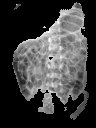

In [ ]:
tf.keras.preprocessing.image.array_to_img(image[0] * pred_mask)

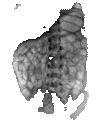

In [ ]:
tf.keras.preprocessing.image.array_to_img(1-(image[0]*pred_mask))

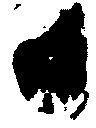

In [ ]:
tf.keras.preprocessing.image.array_to_img(np.ones((128,96,1))-pred_mask)

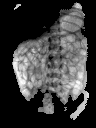

In [ ]:
tf.keras.preprocessing.image.array_to_img(arr_a-arr_black)

Test 이미지 Colormap
- ```tf.keras.preprocessing.image.array_to_img(image[0] * pred_mask)```이미지 저장하고 load하여 color map으로 시각화하기

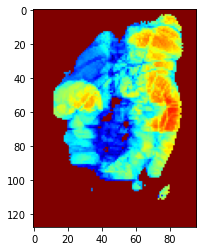

In [ ]:
import cv2

im_gray = cv2.imread('/content/drive/MyDrive/최종 프로젝트/unet_라벨이미지(수정)/Train_validation_image(수정)-validation 나누기/다운로드 (32).png', cv2.IMREAD_GRAYSCALE)
im_color = cv2.applyColorMap(im_gray, cv2.COLORMAP_JET)
plt.imshow(im_color)


In [ ]:
b=tf.keras.preprocessing.image.array_to_img(image[0]*pred_mask)

im_gray = cv2.imread('/content/drive/MyDrive/최종 프로젝트/unet_라벨이미지(수정)/다운로드 (7).jpg', cv2.IMREAD_GRAYSCALE)
im_color = cv2.applyColorMap(im_gray, cv2.COLORMAP_JET)

plt.axis('off')
plt.imshow(im_color)
plt.colorbar(cmap='jet')


In [ ]:
b

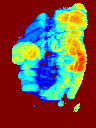

In [ ]:
#array를 이미지로 변환
Image.fromarray(im_color)

---
### 이미지 블렌딩

Test Image

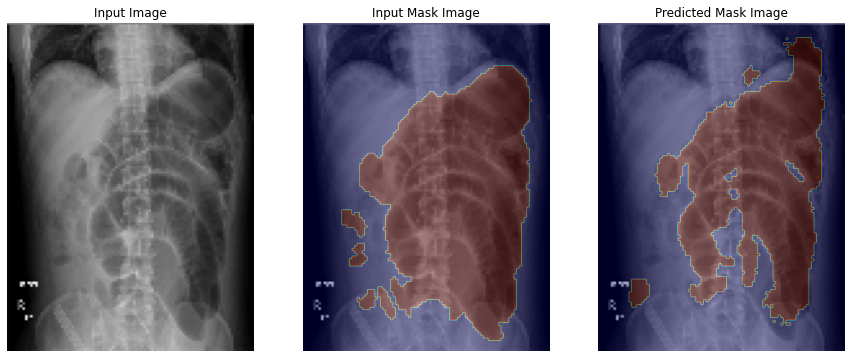

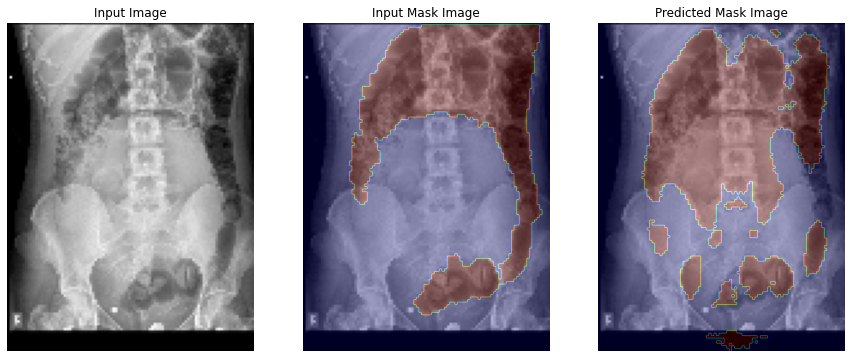

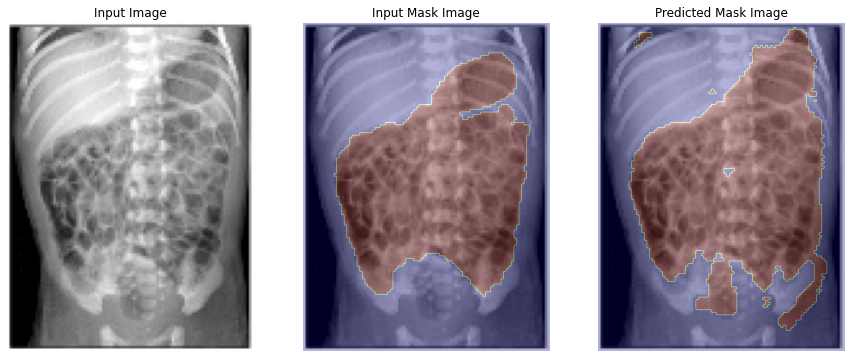

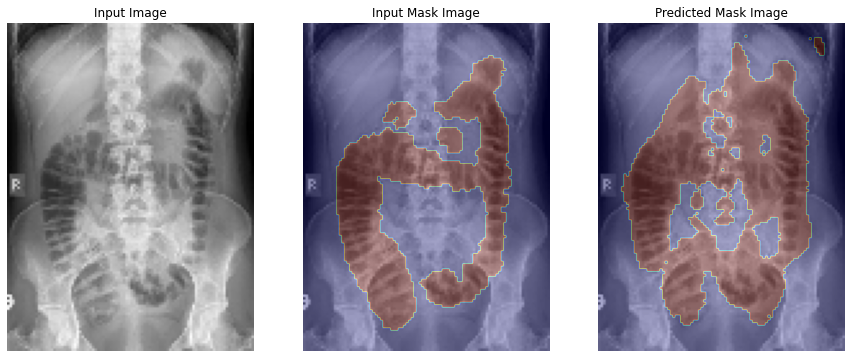

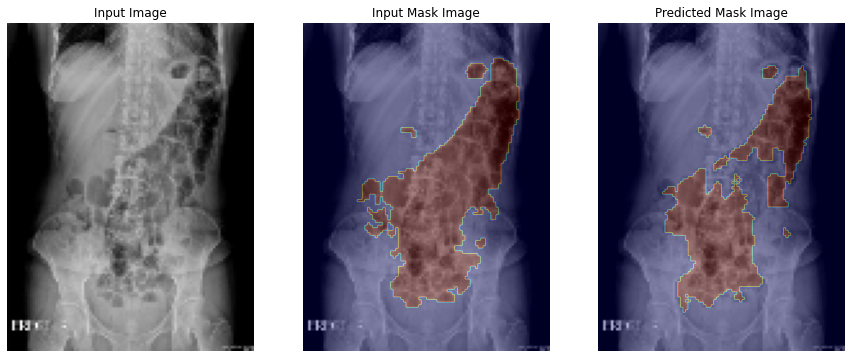

In [ ]:
#Test dataset
def blen_display(display_list):
  plt.figure(figsize=(15,15))
  title = ['Input Image', 'Input Mask Image', 'Predicted Mask Image']
  for i in range(len(display_list)):
    if title[i] == 'Input Image':
      plt.subplot(1, len(display_list), i+1)
      plt.title(title[i])
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
      plt.axis('off')
    elif title[i] == 'Input Mask Image':
      plt.subplot(1, len(display_list), i+1)
      plt.title(title[i])
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i-1]))
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), 'jet', alpha=0.3)
      plt.axis('off')
    elif title[i] == 'Predicted Mask Image':
      plt.subplot(1, len(display_list), i+1)
      plt.title(title[i])
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i-2]))
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), 'jet', alpha=0.3)
      plt.axis('off')
  plt.show()

# 원본 X-Ray이미지와 mask이미지 블렌딩한 이미지 보여줌
def show_blen(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet.predict(image)


      blen_display([image[0], mask[0], create_mask(pred_mask)])

  else:
    blen_display([sample_image, sample_mask,
                  create_mask(unet.predict(sample_image[tf.newaxis, ...]))])
    
show_blen(test_dataset, 20)

## 5. UNet 성능평가 - Image Segmentation 검증지표

1) Mask IOU

- 일반적으로 semantic segmentation의 결과값은 이미지의 크기에 맞는 segmentation map크기와 sementic class 수에 맞는 channel크기를 가짐

__Q. True Mask Image와 Predicted Mask Image를 어떤 방식으로 비교하여 정오여부를 가리는가??__<br>
__A. 픽셀의 수만큼 분류문제로 평가할 수 있음__

1) Mask Intersection-over-Union
- 모델의 성능을 평가할때 True Mask와 Predicted Mask 사이의 IOU를 사용
- 실제값과 예측값이 얼마나 겹치는지를 따져 잘 예측했는지 성능을 평가하는 지표


In [ ]:
intersection = np.logical_and(mask[0], pred_mask)
type(intersection)

numpy.ndarray

Test IOU

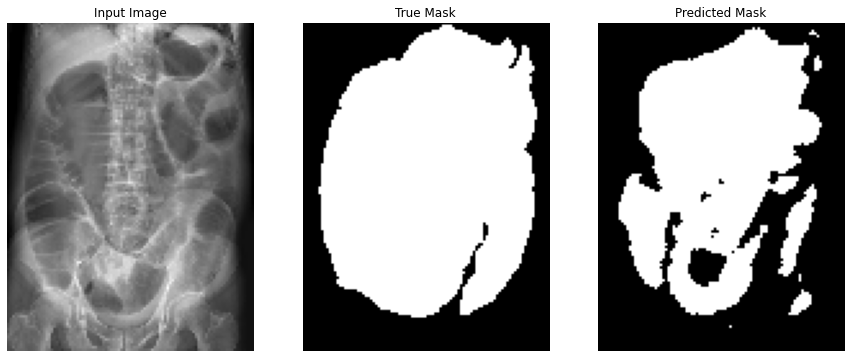

0.7092522510766018


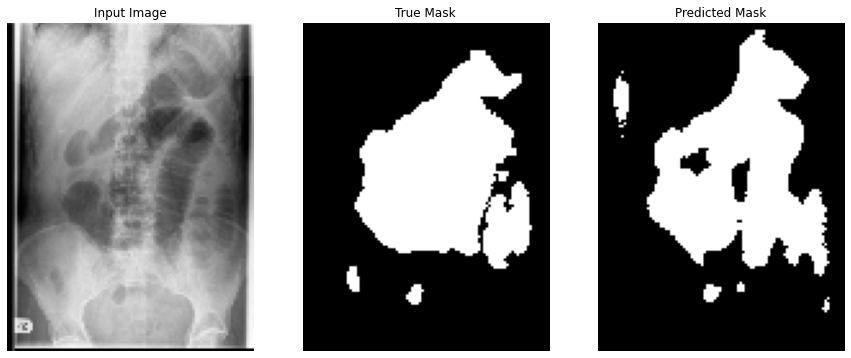

0.7843937575030012


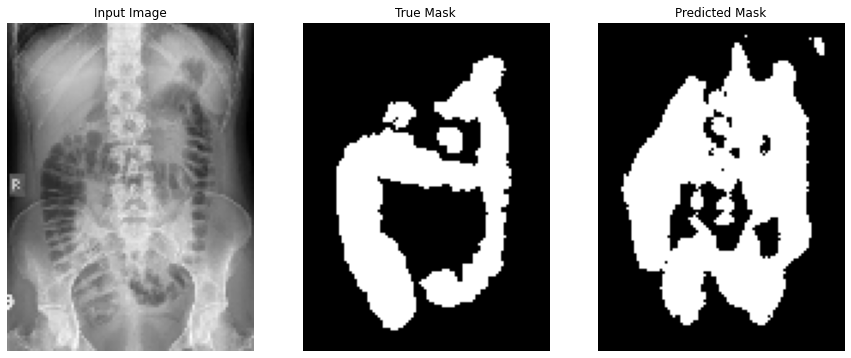

0.6127110228401191


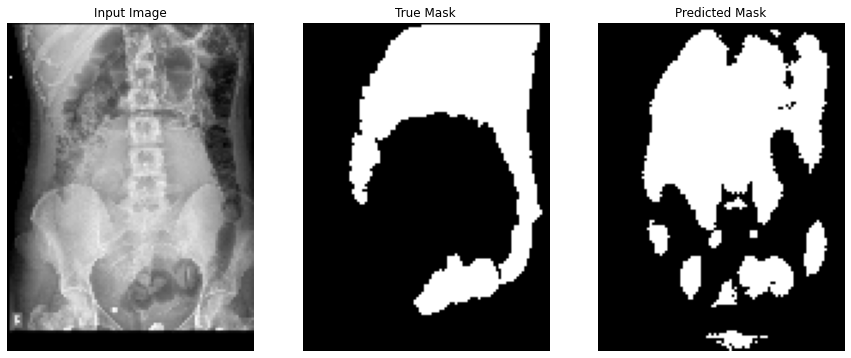

0.5100113335851908


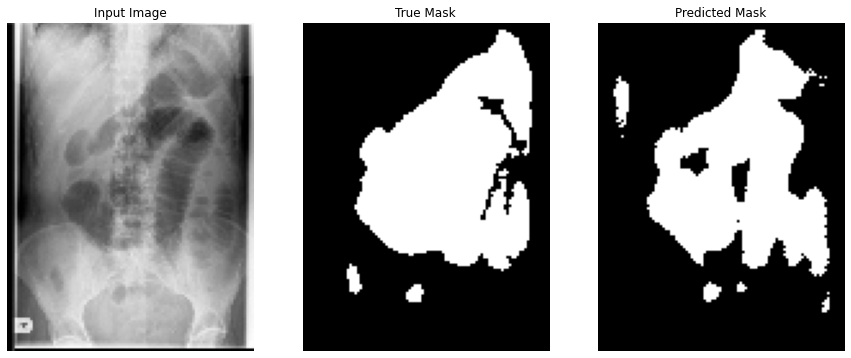

0.7305609703270523


In [ ]:
#test
for image, mask in test_dataset.take(6):
  pred_mask = unet.predict(image)
  pred_mask = create_mask(pred_mask).astype(tf.float32)
  display([image[0], mask[0], pred_mask])

  intersection = np.logical_and(mask[0], pred_mask)
  union = np.logical_or(mask[0], pred_mask)
  iou_score = np.sum(intersection)/np.sum(union)
  print(iou_score)

In [ ]:
for image, mask in test_dataset.take(9):
  pred_mask = unet.predict(image)
  pred_mask = create_mask(pred_mask).astype(tf.float32)
  

  intersection = np.logical_and(mask[0], pred_mask)
  union = np.logical_or(mask[0], pred_mask)
  iou_score = np.sum(intersection)/np.sum(union)
  print(iou_score)

0.7305609703270523
0.6127110228401191
0.6789641716920894
0.8111349803079126
0.5100113335851908


In [ ]:
#test 평균 IOU
test = [0.8111349803079126,
0.6789641716920894,
0.7843937575030012,
0.7199617956064948,
0.8702568351284176,
0.5100113335851908,
0.7092522510766018,
0.7305609703270523,
0.6127110228401191]

test = np.array(test)

te_iou = sum(test)/len(test)
print('test의 평균 IOU score:', round(te_iou, 2))

test의 평균 IOU score: 0.71


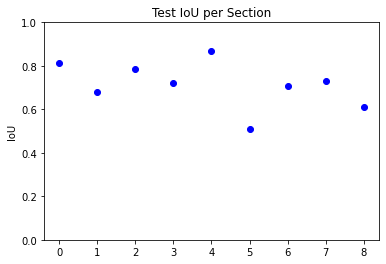

In [ ]:
plt.ylim(0, 1)
plt.ylabel('IoU')
plt.title('Test IoU per Section')
plt.plot(test, 'bo')

In [ ]:
test_2=[0.6195718654434251,
0.7470039946737683,
0.7608108108108108,
0.5494972931167826,
0.5116223908918406,
0.6695368558382258,
0.6513904338153504,
0.6453995970449966,
0.6054729584141348]

test_2 = np.array(test_2)

te_ = sum(test_2)/len(test_2)
print('test의 평균 IOU score:', round(te_, 2))

In [ ]:
plt.ylim(0, 1)
plt.ylabel('IoU')
plt.xlabel('Data')
plt.title('Test IoU per Section')
plt.plot(test_2, 'bo')